# Temos a base de dados Amostra, farei a mineiração dos dados dos campos ('ds', 'y') para executar o Modelo de Previsão de Séries Temporais, o Prophet:
1) Campo Data da Aplicação da Vacina ('ds')
2) Campo Data Descricao Dose 1. Dose e 2. Dose ('y')

In [ ]:
# DATA de Atualização; 06/06/2021

In [2]:
# Importando as principais Bibliotecas:

import csv
import time
import requests 
import pandas  as pd
import numpy   as np
import seaborn as sns
from random   import random
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:

from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet             import Prophet
from prophet.plot        import plot_plotly
from prophet.plot        import plot_cross_validation_metric
from prophet.plot        import plot_components_plotly
from prophet.plot        import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot        import plot_cross_validation_metric

# Leitura Banco Dados da Amostra no dia 26/05/2021:

df = pd.read_csv("BD_Amostra-Alguns-26-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']

In [3]:
# Definindo Variaveis Globais:

FATOR_AMOSTRA = 0.001 # É o valor da porcentagem obtida pelo Banco de Dados Amostra: 1/1000

# 1.º passo: 

1) Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"\
2) Denifir que o campo 'vacina_dataAplicacao' terá somente a DATA no formato: AAAA/MM/DD\
3) Remover o TimeZone do campo DATA


In [4]:
# Converter a coluna "vacina_dataAplicacao," datetime somente em date e tratando TimeZOne:

df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date

df.dtypes

vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [5]:
# Deixando a coluna "vacina_dataAplicacao" que será utilizada no Algoritmo de Previsão de Séries Temporais:

df['vacina_dataAplicacao']

0        2021-03-19
1        2021-03-03
2        2021-03-09
3        2021-04-01
4        2021-03-25
            ...    
61473    2021-05-25
61474    2021-05-07
61475    2021-05-25
61476    2021-05-25
61477    2021-05-25
Name: vacina_dataAplicacao, Length: 61478, dtype: object

In [6]:
# Ordenando a coluna data: "vacina_dataAplicacao".

# Uma das premissas para se trabalhar com série temporal é que 
# devemos manter a ordem correta dos acontecimentos dos eventos.
# Portanto, vamos ordenar a coluna "vacina_dataAplicacao".


df = df.sort_values('vacina_dataAplicacao')
df['vacina_dataAplicacao'].reset_index()

,index,vacina_dataAplicacao
0,25187,2020-03-23
1,26044,2020-03-23
2,51822,2020-03-23
3,20580,2021-01-18
4,1569,2021-01-18
...,...,...
61473,20311,2021-05-25
61474,20309,2021-05-25
61475,20302,2021-05-25
61476,20213,2021-05-25


# 2.º Passo: 
Tratando do campo "vacina_descricao_dose": identificar quais doses foram tomadas da vacina:

   - Primeira Dose 
   - Segunda Dose após um intervalo definido
   - Dose única

In [ ]:

df["vacina_descricao_dose"].unique()

# 2.1 Tratando o campo "vacina_descricao_dose":

1) Transformando todos as linhas como Minuúsculas \
2) Quando aparecer Null (NaN) substituir por "-" \
3) Tratando todos os caracteres ASCII 

In [7]:

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

## 2.2 Calculando as doses aplicadas por dia da coluna: 'vacina_descricao_dose':

Teremos 3 situações para contabilizar o número de vacinas tomadas:
  1) A Primeira Dose ==> 1a_dose\
  2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose\
  3) Ser Dose Unica!!

In [8]:
# Verificando o valor acumulado das doses tomadas:

df["vacina_descricao_dose"].value_counts()

1a_dose    42101
2a_dose    19376
unica          1
Name: vacina_descricao_dose, dtype: int64

# 2.3  Função: Get_Dummies no campo 'vacina_descricao_dose':

1) se não tomou vacina da 1ª Dose' = 0, se tomou a 1ª Dose' = 1 \
2) se não tomou vacina da 2ª Dose' = 0, se tomou a 2ª Dose' = 1

In [9]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")
dummies

,1a_dose,2a_dose,unica
25187,1,0,0
26044,1,0,0
51822,1,0,0
20580,1,0,0
1569,1,0,0
...,...,...,...
20311,0,1,0
20309,1,0,0
20302,1,0,0
20213,1,0,0


# 2.4  Concatenar a coluna Dummies ao DataFrame:

In [10]:
# Preparando nosso Dataframe:

df = pd.concat([df, dummies], axis = 1)

# Após Concat com o Dummies, o Dataframe df acrescenta mais 3 colunas no df:

# Note que nosso DataFrame df conterá 9 colunas:
df.shape

(61478, 9)

# 3.º Passo: 
Fazendo o cálculo para valores com o FATOR_AMOSTRA

In [11]:
Vacinados_uma_dose = df['1a_dose'].sum()

print('Total REAL de Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Total REAL de Vacinados com 1. dose =  42101000.0


In [12]:
Vacinados_duas_doses = df['2a_dose'].sum()

print('Total REAL de Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Total REAL de Vacinados com 2. dose =  19376000.0


In [13]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

In [ ]:
# Plotting das Doses tomadas:

plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

# 3.1 Trabalhando com informações da '1a_dose' 
para executar o algoritmo de PREVISAO:
Neste ponto, vou definir o DataFrame df1 para '1a_dose'

In [14]:
# Agrupando as colunas da Data da Aplicacao com os vacinados da '1a_dose'

df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()

2021-05-19    1
2021-02-25    1
2021-02-23    1
2021-03-19    1
2021-05-09    1
             ..
2021-04-16    1
2021-01-24    1
2021-02-04    1
2021-02-08    1
2021-03-29    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

# 4.º Passo: 

Preparando para rodar o Algoritmo do Prophet para Previsao Séries Temporais: \
dois campos importantes 'ds' e 'y', onde:\
ds       => é a coluna DATA e já está no formato de AAAA-MM-DD\
coluna y => deve ser numérica e representa a medida que desejamos prever:\

A coluna 'y' contém a soma diária das doses e separando em duas etapas as previsões: \
 y = 1.dose total da para dataframe ==> df1 \
 y = 2.dose para dataframe          ==> df2

In [15]:
# A primeira etapa será previsão da 1.dose:

df1.tail(5)

,vacina_dataAplicacao,1a_dose
124,2021-05-21,342
125,2021-05-22,231
126,2021-05-23,26
127,2021-05-24,294
128,2021-05-25,235


# Importante: 
É necessário renomear os nomes das colunas 'ds' e'y' para rodar o Prophet

In [16]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:


df1.columns = ['ds', 'y']

<AxesSubplot:title={'center':'Tempo Data Series'}, xlabel='ds'>

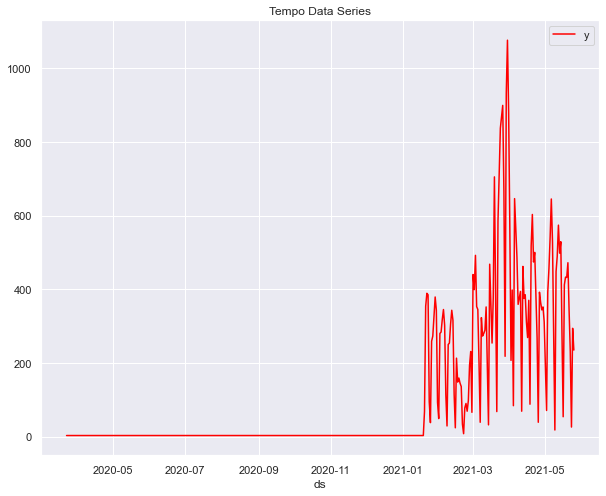

In [17]:
# Plotting the TIme Series Data:

df1.plot(x ='ds', y ='y', figsize = (10,8), title = 'Tempo Data Series' , color = 'red')

No handles with labels found to put in legend.


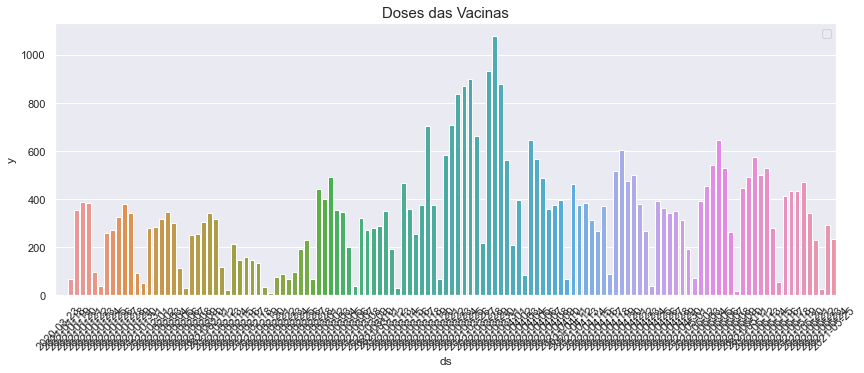

In [18]:
# Plotting Doses Vacinas:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
ax      = sns.barplot(x= "ds", y="y", data = df1)


ax.set_title("Doses das Vacinas", fontsize=15)

# Somente tirando a legenda para fora do gráfico:

plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.show()


# 5.º Passo: 
## Executando o Modelo de Prophet() - Primeiro Modelo, model1:

Executando o primeiro modelo do algoritmo Prophet(), sem fornecer nenhum parâmetros:

In [19]:
# Fazendo Saturações Previsões de Crescimento: Modelo Prophet

model1 = Prophet(interval_width = 0.95) # por padrao é 0.80%

# Faremos o treinamento o meodelo:

model1.fit(df1)


# O Prophet disponibiliza um dataframe adequado que se estenda para o futuro 
# por um número especificado de dias (que escolhemos para prever) 
# usando o método auxiliar `make_future_dataframe.

future1   = model1.make_future_dataframe(periods = 365) # previsão de 1 ano 


# O método PREDICT, atribuirá cada linha em future um valor previsto que ele nomeia "yhat". 
# Se você passar datas históricas, isso fornecerá um ajuste na amostra. 
# O objeto FORECAST é um novo dataframe que inclui uma coluna yhatcom a previsão, 
# bem como colunas para componentes e intervalos de incerteza.

forecast1 = model1.predict(future1)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# O forecast é o nosso DataFrame de previsão, as colunas mais importantes são:
# ds, yhat, yhat_lower e yhat_upper, onde:

# yhat = previsão prevista
# yhat_lower = limite inferior das nossas previsões
# yhat_upper = limite superior

# OBS:  yhat_lower e yhat_upper: são as componentes do intervalo de incertezas,
# quanto mais distante o tempo à frente, mais incerto fica a previsão.

forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
489,2022-05-21,840.911142,500.771099,1193.991314
490,2022-05-22,643.027603,311.477301,999.330936
491,2022-05-23,993.534785,662.304096,1350.745541
492,2022-05-24,990.130664,668.369785,1325.861604
493,2022-05-25,1020.635811,713.005491,1342.260735


In [22]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-23,-111.823759,-434.811465,231.517690
1,2021-01-18,308.799410,-33.563661,644.056055
2,2021-01-19,305.395289,-31.748506,634.537253
3,2021-01-20,335.900435,-15.088565,688.658783
4,2021-01-21,322.937095,-3.015011,643.295400


# 6.º Passo:
# Fazendo os gráficos com as previsões obtidas para cada modelo:


Teremos alguns modelos testados e faremos uso do utilitário performance_metrics:\
1) para calcular o erro quadrático médio (MSE), \
2) erro quadrático médio (RMSE), \
3) erro absoluto médio (MAE), \
4) erro percentual médio absoluto (MAPE)\

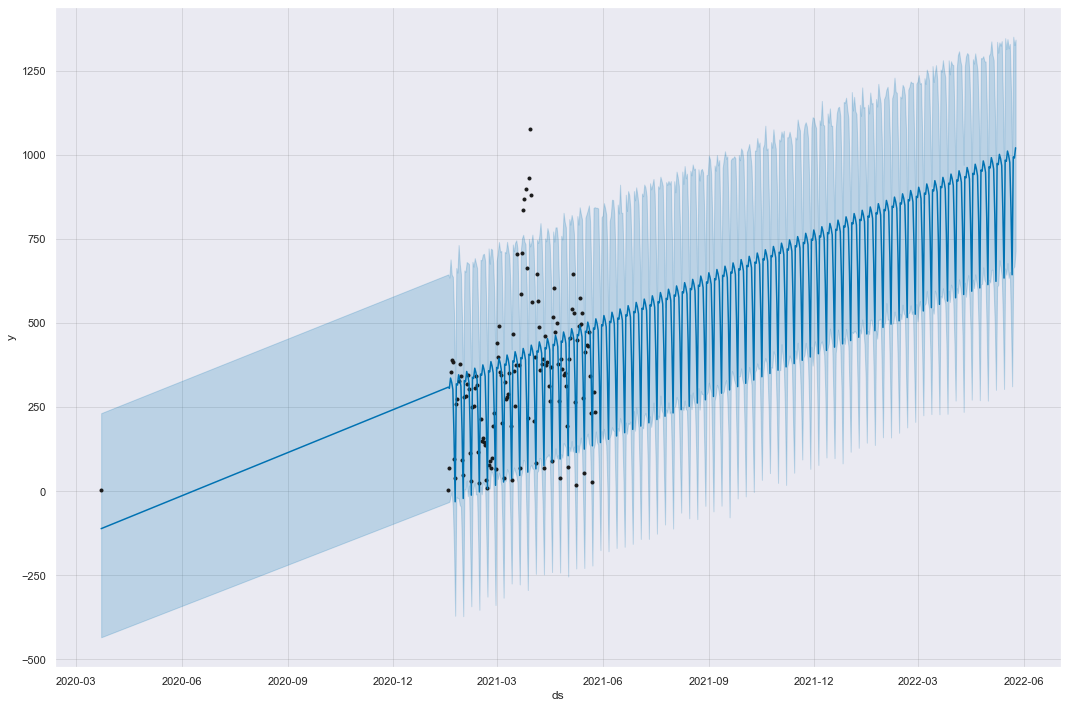

In [23]:
# Plotting: Traçando as Previsôes, primeiro  modelo testado, sem parâmetros:

# fig1 = model1.plot(forecast1)

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)
fig = model1.plot(forecast1,ax=ax)
plt.show()


In [ ]:
# Comentando sobre o grafico da fig1, acima:

# Sobre o gráfico acima, os pontos pretos são o total de vacinados. 
# O tom azul representa o intervalo de confiança de 80% em torno da previsão, por padrão, onde o
# modelo tenta ajustar todos os pontos de dados suavemente.
#

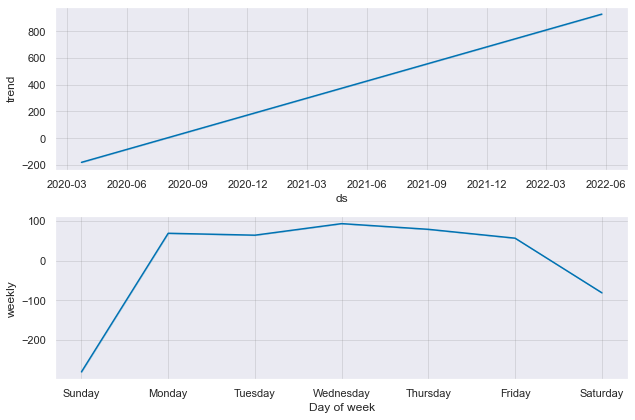

In [24]:
# Plotting os componentes da Previsão:

fig2 = model1.plot_components(forecast1)

<AxesSubplot:title={'center':'Data Atual x Previsão'}, xlabel='ds'>

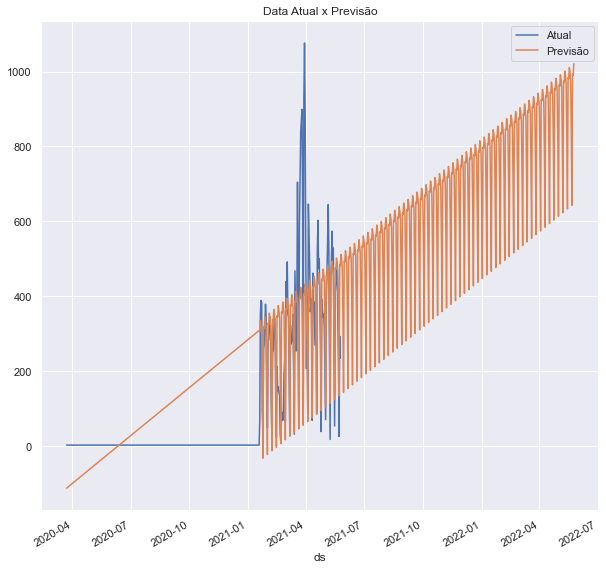

In [25]:
# Plotting os valores: Atual ('y') e a Previsão obtidos do Forecast{'yhat'}:

ax = (df1.plot(x = 'ds', y = 'y',  figsize =(12,8), label='Atual', title = "Data Atual x Previsão"))
forecast1.plot( x = 'ds', y ='yhat',figsize =(10,10), label ='Previsão' ,title = "Data Atual x Previsão", ax =ax )

# 7.º Passo:
 
## Função Cross-Validation do primeiro modelo, nem nenhuma alteração dos pariametros:

Esse procedimento de validação cruzada pode ser feito automaticamente para uma faixa de cortes históricos usando a função cross_validation. 

Especificamos:
1) o horizonte de previsão (horizon) \
2) opcionalmente, o tamanho do período de treinamento inicial ( initial) \
3) o espaçamento entre as datas de corte ( period), o período de treinamento inicial \
é definido como três vezes o horizonte e os cortes são feitos a cada meio horizonte.\

# Entendendo a saída do resultado Cross_Validation:
A saída de cross_validation é um dataframe com os valores reais 'y' 
e os valores de previsão fora da amostra 'yhat', em cada data de previsão simulada e para cada data de corte.
Em particular, uma previsão é feita para cada ponto observado entre cutoffe cutoff + horizon. Esses dados podem então ser usados para medidas de erro de computação de 'yhat' e 'y'.

Aqui, fazemos validação cruzada para avaliar:
1) desempenho da previsão em um horizonte de 30 dias, \
2) começando com 365 dias de dados de treinamento no primeiro corte \
3) fazendo previsões a cada 10 dias.

In [26]:
# Utilizando a Função Cross-Validation

df_cross1 = cross_validation(model1, initial = '365 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


In [27]:
# Vericando as Metricas:

df_perform1 = performance_metrics(df_cross1)
df_perform1.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,55413.198890,235.400083,174.804529,0.435551,0.431214,0.446463,0.833333
1,4 days,79388.158407,281.759043,181.076638,0.382542,0.383579,0.406624,0.833333
2,5 days,99616.722685,315.621170,226.866075,0.419973,0.438740,0.440680,0.750000
3,6 days,74629.965341,273.184856,186.657667,0.441455,0.330680,0.410693,0.833333
4,7 days,34342.031905,185.316033,141.064354,0.560631,0.398658,0.421930,0.916667


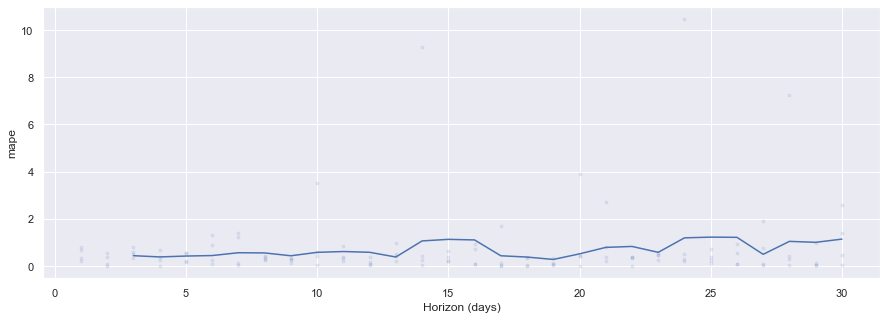

In [28]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross1, metric='mape', figsize = (10,30), ax=ax)

plt.show()


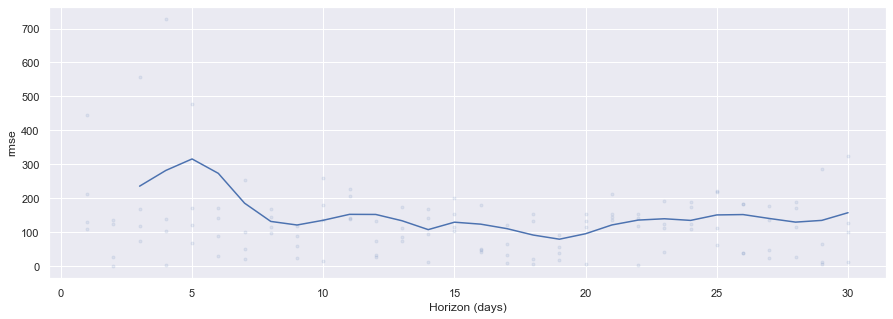

In [58]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross1, metric='rmse', figsize = (10,30), ax=ax)

plt.show()

# 8.º Passo:

## Segundo Modelo - Model2:

Ajustando Parâmetros para melhorar a previsão:\
Fazendo os ajustes no parâmetros do modelo do Prophet para que os valores das previsões\
sejam positivos:\

Note que o nome do modelo será model1 com os parâmetros do Prophet serão ajustados:

1) 'interval_width = 0.95' para definir o intervalo de incerteza, para produzir um \
intervalo de confiança em torno da previsão;\
2) alterando os valores de sazonalidade: diaria,semanal, mensal e anual;\
3) mudando o valor de changepoint_prior = 2\


In [30]:
# Gerando segundo modelo, model2 com os parâmetros:

model2 = Prophet(interval_width = 0.95, # por padrão é 0.80%
               changepoint_prior_scale = 2,
               daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
  
    
model2.fit(df1)
future2   = model2.make_future_dataframe(periods = 365) # previsão de 1 ano 
forecast2 = model2.predict(future2)


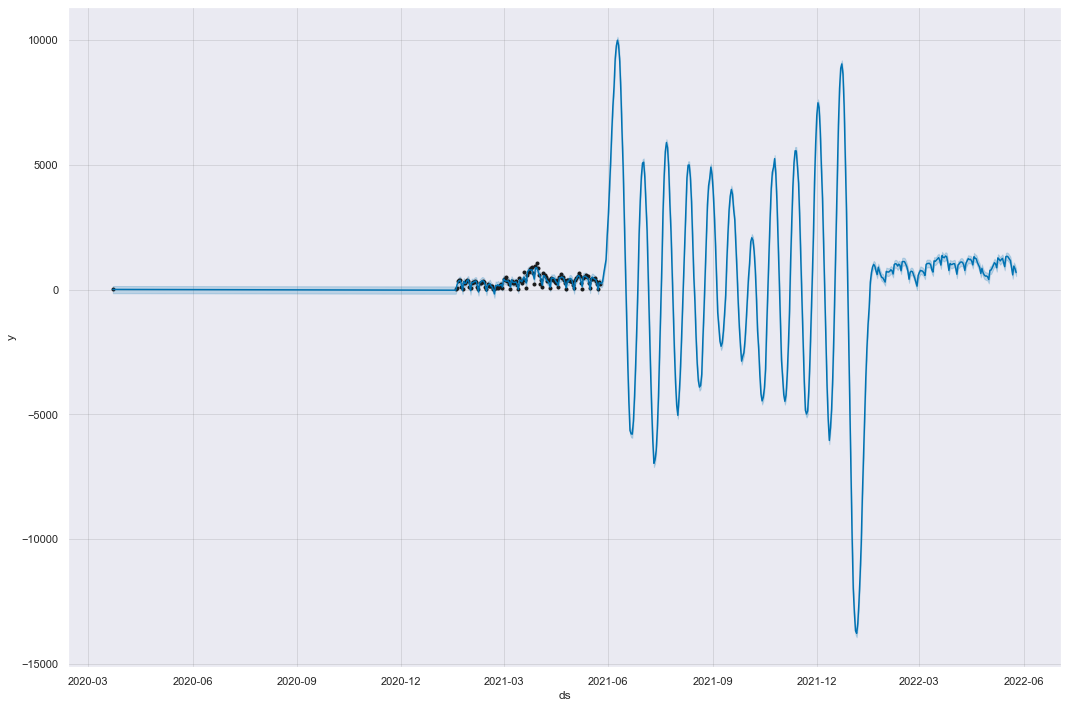

In [33]:
# Plotting: Traçando as Previsôes para model2:

# fig5 = model2.plot(forecast2)

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)
fig4 = model2.plot(forecast2,ax=ax)
plt.show()


In [34]:
# Utilizando a Função Cross-Validation

df_cross2 = cross_validation(model2, initial = '365 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


In [35]:
# Verificando as Métricas do Modelo2:

df_perform2 = performance_metrics(df_cross2)
df_perform2.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,8.089168e+05,899.398037,627.183031,2.301541,0.954885,0.746559,0.25
1,4 days,2.463229e+06,1569.467770,1284.976289,3.805816,2.878302,1.203598,0.00
2,5 days,6.029210e+06,2455.445006,2197.595204,5.846826,5.155121,1.529421,0.00
3,6 days,1.359261e+07,3686.815471,3411.756659,15.066350,7.590218,1.715157,0.00
4,7 days,2.713893e+07,5209.503546,4924.207599,27.289987,11.573191,1.807371,0.00


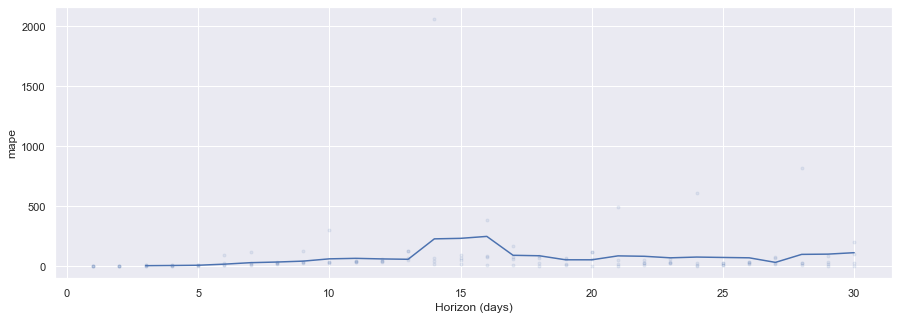

In [68]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do segundo modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross2, metric='mape', figsize = (10,30), ax=ax)

plt.show()


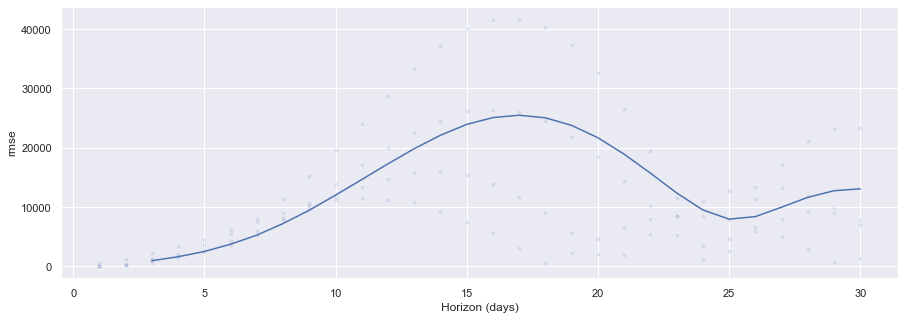

In [69]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross2, metric='rmse', figsize = (10,30), ax=ax)

plt.show()

# Testando um novo modelo, model3:

## Aqui o ajuste principal que fará a diferença dos modelos anteriores será 
a definição do parâmetro "grown = logistic", crescimento logístico:\
O objetivo será que a previsão ficar positiva: \
2) Alterando o parâmetro do grown = 'logistic', torna-se necessário mudar\
- o limite (valor máximo que seus dados alcançarão)  \
- o piso (valor mínimo que seus dados alcançarão)\
3) changepoint_range

OBS: O limite máximo da população vacinada é de 211.755.692 de brasileiros, \
pois muito provavelmente não atingirá esse limite dentro do tempo que está prevendo. \
Vou definir algo mais razoável, como 500.000, e deixar o limite aumentar lentamente com o tempo.

4) changepoint_prior_scale: é provavelmente o parâmetro de maior impacto, o argumento \
de entrada changepoint_prior_scale, por padrão, este parâmetro é definido como 0,05, \
aumentar tornará a tendência mais flexível.\

OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
valores Mínimo e Máximo

Foi definido o parâmetro Future['cap'] = 500.000 corresponderá ao número máximo de
brasileiros vacinados.


In [36]:
# Fazendo o terceiro modelo, model3 com alteração de outros parâemtros:


df1['cap']  = 7000   # media vacinados por dia
df1['floor'] = 1      # valor do piso

model3 = Prophet(growth = 'logistic', changepoint_range = 1, changepoint_prior_scale = 2)

# Calculando treinamento:
model3.fit(df1)

# Fazendo a previsão:

future3 = model3.make_future_dataframe(periods = 365)


future3['cap']   =   500000                # Representa Populacao Brasileira = 211755692  
future3['floor'] = 1

forecast3 = model3.predict(future3)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


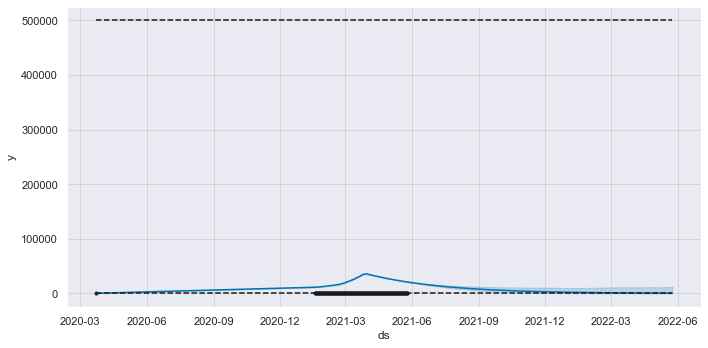

In [77]:
# Plotting  forecast modelo3:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fig6 = model3.plot(forecast3,ax=ax)
plt.show()


In [59]:
# Utilizando a Função Cross-Validation para Modelo 3:

df_cross3 = cross_validation(model3, initial = '365 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


In [39]:
df_cross3.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-27,643.782613,516.358184,775.638232,664,2021-03-26
1,2021-03-28,556.336849,422.494936,686.166769,218,2021-03-26
2,2021-03-29,845.159962,709.105892,974.718864,932,2021-03-26
3,2021-03-30,886.616087,754.244597,1024.070590,1076,2021-03-26
4,2021-03-31,981.240393,851.616739,1110.354329,880,2021-03-26


In [60]:
# Vericando as Metricas, model3:

df_perform3 = performance_metrics(df_cross3)
df_perform3.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,38551.459031,196.345255,139.972552,0.409959,0.180232,0.290156,0.750000
1,4 days,52332.763032,228.763553,170.281181,0.456664,0.195781,0.323070,0.583333
2,5 days,45037.090675,212.219440,158.810784,0.355501,0.157893,0.278946,0.583333
3,6 days,64233.255670,253.442806,195.228176,0.847515,0.195781,0.391912,0.500000
4,7 days,128883.073976,359.002889,256.479204,1.236847,0.504942,0.572785,0.500000


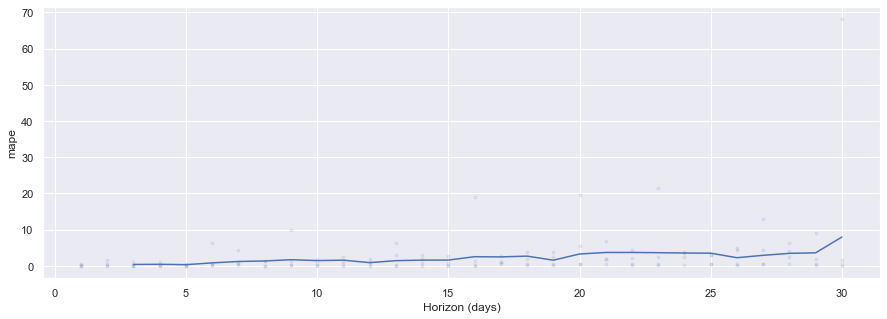

In [63]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross3, metric='mape', figsize = (10,30), ax=ax)

plt.show()


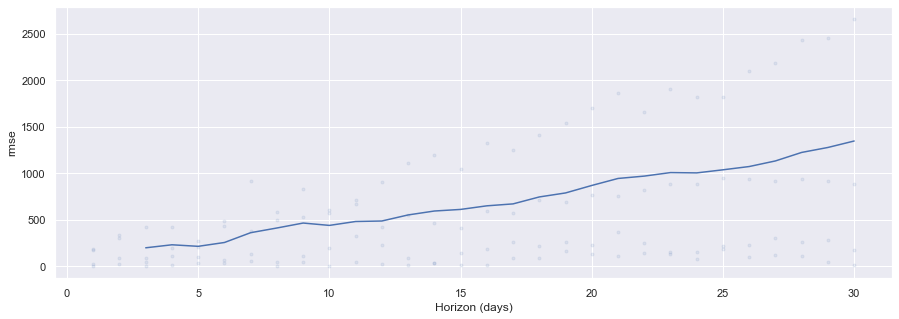

In [65]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross3, metric='rmse', figsize = (10,30), ax=ax)

plt.show()

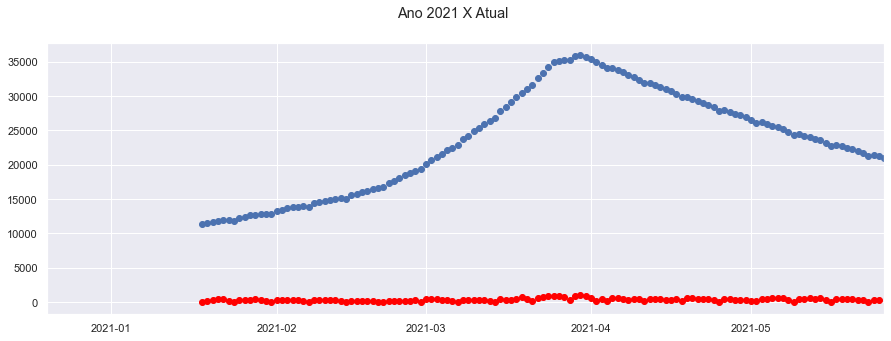

In [43]:
# Plotting Forecast:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Inicio da Vacinação no Brasil 18/12/2020

ax.scatter(df1['ds'], df1['y'], color='red', label="Atual")
ax.scatter(forecast3['ds'], forecast3['yhat'], label= 'Previsao')

# Plotting o atual e os valores obtidos do Forecast:

ax.set_xbound(lower ='2020-12-20', upper ='2021-05-26')
# ax.set_ylim(0, 1000)
plot = plt.suptitle('Ano 2021 X Atual')

In [ ]:
# Fazendo o Plotagem da Previsão:

fig4 = model.plot(forecast, uncertainty = True)

fig5 = model.plot_components(forecast)

In [ ]:
# Plotting comparando valores: Atual x Futuro: 

ax = (df1.plot(x= 'ds', y = 'y',   legend = True, label = 'Data', figsize= (10,30), color = 'red')) 
forecast.plot(x= 'ds',  y ='yhat', legend = True, label = 'Previsao', figsize=(10,10),title='DADOS ATUAIS X FUTURO', color ='blue',ax=ax)

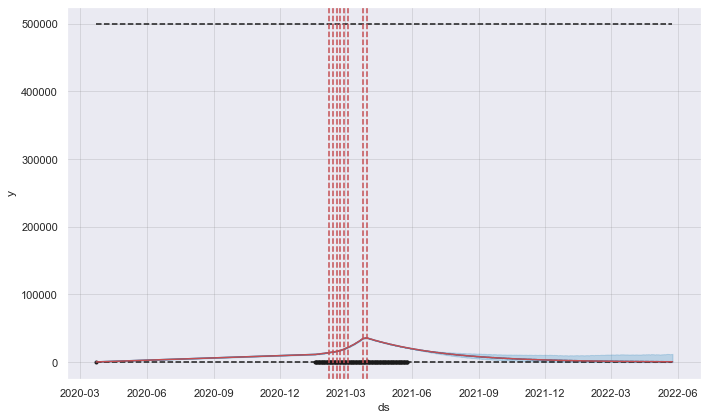

In [46]:
# Plotting dados Atual x Futuro

fig = model3.plot(forecast3)
a   = add_changepoints_to_plot(fig.gca(), model3, forecast3)

# 11.º Passo:
# Testando o quarto modelo, model4 com os feriados:
Adicionando os feriados deste ano de 2021/2022 do calendário do Brasil:

In [47]:
# Adicionando os Feriados do Brasil para melhorar a acurária da Previsão da Serie Temporal:

import holidays
    
feriado = holidays.Brazil()

# Feriados no Brasil:
for feriado in feriado['2021-01-01': '2022-12-31'] :
    print(feriado)

2021-01-01
2021-02-16
2021-02-17
2021-04-02
2021-04-04
2021-04-21
2021-05-01
2021-06-03
2021-09-07
2021-10-12
2021-11-02
2021-11-15
2021-12-25
2022-01-01
2022-03-01
2022-03-02
2022-04-15
2022-04-17
2022-04-21
2022-05-01
2022-06-16
2022-09-07
2022-10-12
2022-11-02
2022-11-15
2022-12-25


In [48]:
# Definindo os feriados do calendário do Brasil:

playoffs = pd.DataFrame ({
  'holiday': 'playoff', 
  'ds': pd.to_datetime (['2021-01-01', '2021-02-16', '2021-02-17', '2021-04-02', '2021-04-04', 
                          '2021-04-21', '2021-05-01', '2021-06-03', '2021-09-07', '2021-10-12',
                          '2021-11-02', '2021-11-15', '2021-12-25',
                          '2022-01-01', '2022-03-01', '2022-03-02', '2022-04-15', '2022-04-17',
                          '2022-04-21', '2022-05-01', '2022-06-16', '2022-09-07', '2022-10-12',
                          '2022-11-02', '2022-11-15', '2022-12-25'
                        
                        ]), 
  ' lower_window ': 0, 
  ' upper_window ': 1, 
})

others = pd.DataFrame({  
  'holiday': 'others',
  'ds': pd.to_datetime(['2021-07-09', '2021-11-20']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, others))

# 12.º Informando os feriados do calendário e rodando novamente o Prophet
para verificar se houve melhoria da previsao

In [49]:
df1['cap']  = 7000   # media vacinados por dia
df1['floor'] = 1      # valor do piso

model4 = Prophet(growth = 'logistic', changepoint_range = 1, changepoint_prior_scale = 2, holidays=holidays)

# Calculando treinamento:
model4.fit(df1)

# Fazendo a previsão:

future4 = model4.make_future_dataframe(periods = 365)


future4['cap']   = 500000                # Representa Populacao Brasileira = 211755692  
future4['floor'] = 1

forecast4 = model4.predict(future4)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


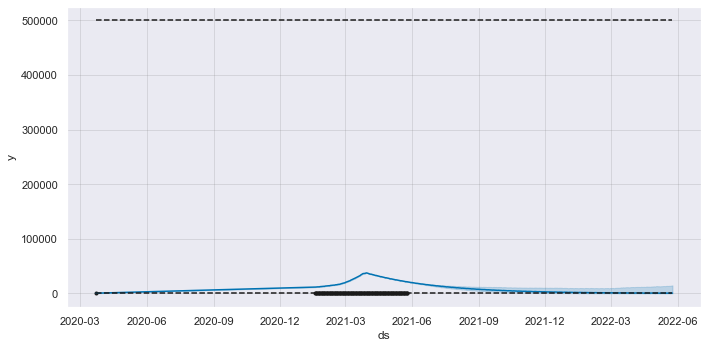

In [79]:
# Plotting o forecast do quarto modelo, model4:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fig8 = model4.plot(forecast4, ax=ax)
plt.show()

In [52]:
# Recalculando a Função Croos-Validation do modelo 4:

df_cross4 = cross_validation(model4, initial='365 days', period='10 days', horizon = '30 days')

df_cross4.head()
df_perform4 = performance_metrics(df_cross4)
df_perform4.head()



INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,52203.966931,228.481874,164.006921,0.463985,0.234847,0.324191,0.583333
1,4 days,70116.361391,264.794942,194.638974,0.518420,0.224356,0.356497,0.583333
2,5 days,61293.182215,247.574599,181.338205,0.414373,0.182654,0.308202,0.583333
3,6 days,92297.590313,303.805185,248.692106,1.104108,0.473704,0.578355,0.416667
4,7 days,140422.250110,374.729569,301.120425,1.440153,0.710962,0.739896,0.416667


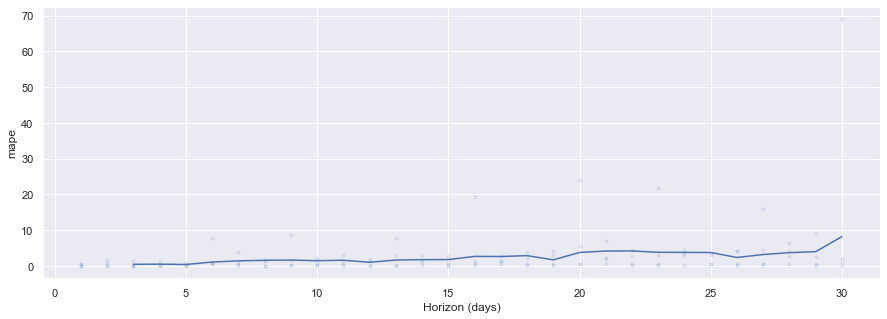

In [54]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='mape', figsize = (10,30), ax=ax)

plt.show()


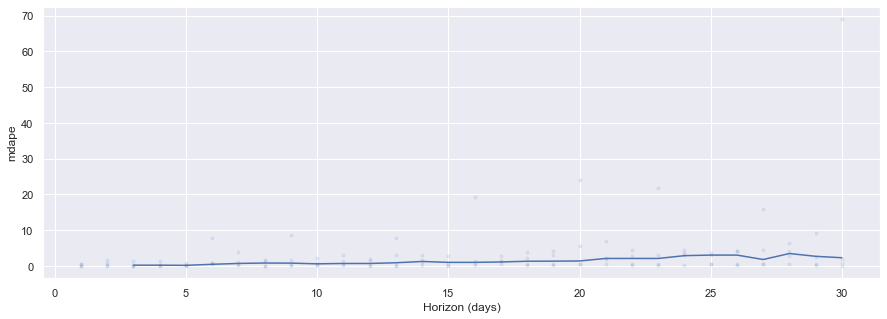

In [55]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='mdape', figsize = (10,30), ax=ax)

plt.show()


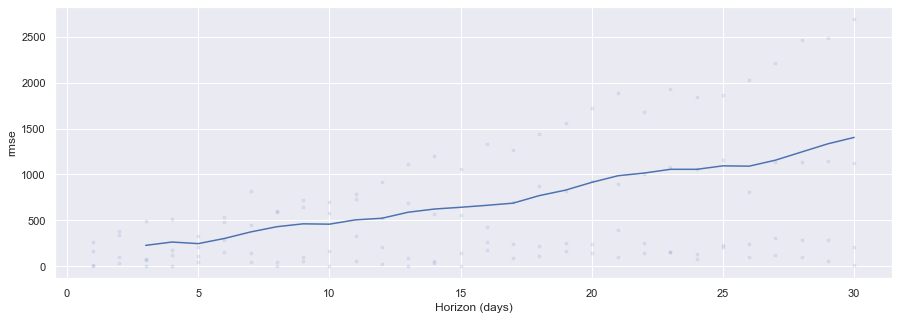

In [67]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='rmse', figsize = (10,30), ax=ax)

plt.show()


# Finalizamos com a análise da vacina '1. Dose'
## Conclusão: 
a melhor performance obtida pelo algoritmo Prophet 
foi no terceiro Propet, quando foi definido o parâmetro growth = logistic com os valores dos piso e teto. No quarto modelo, seguindo com os mesmos paarámetros do terceiro modelo, 
acrescentando os feriados para melhorar a previsão do algoritomo.



A segunda vez que foi rodado o algoritmo alterando os parámetros, na
computação com os valores obtido do MAPE foram os mais altos.
E no final, a configuração do calendário de feriados no Brasil, foi melhor
do que a segunda vez, mas a primeira execução obtive os melhores valores.


# 13.º Passo:
Neste ponto estarei fazendo as Previsões da Segunda Dose da Vacina:
Praticamente são os mesmos procedimentos da 1. Dose da vacina

In [80]:
df2 = df
df2.shape

(61478, 9)

In [81]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()

2021-05-19    1
2021-02-25    1
2021-02-23    1
2021-03-19    1
2021-05-09    1
             ..
2021-04-16    1
2021-01-24    1
2021-02-04    1
2021-02-08    1
2021-03-29    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

In [83]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df2.columns = ['ds', 'y']

In [ ]:
df2

<AxesSubplot:title={'center':'Datas Vacinação da 2. Dose'}, xlabel='ds'>

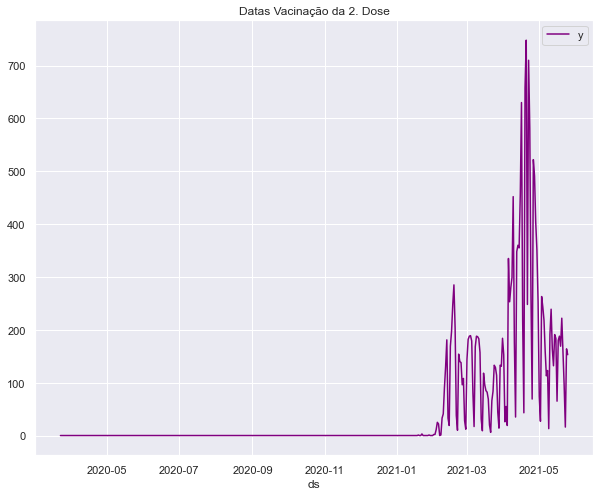

In [88]:
# Plotting Data Atual

df2.plot(x ='ds', y ='y', figsize = (10,8), title = 'Datas Vacinação da 2. Dose' , color = 'purple')

# Aqui farei o modelo Prophet com os parâmetros do quarto modelo da 1.dose, 
# pois os testes são semelhantes.

In [89]:
df2['cap']  = 7000   # media vacinados por dia
df2['floor'] = 1      # valor do piso

# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 

modelS = Prophet(growth = 'logistic', changepoint_range = 1, changepoint_prior_scale = 2, holidays=holidays)

# Calculando treinamento:
modelS.fit(df1)

# Fazendo a previsão:

futureS = modelS.make_future_dataframe(periods = 365)


futureS['cap']   = 500000                # Representa Populacao Brasileira = 211755692  
futureS['floor'] = 1

forecastS = modelS.predict(future4)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [90]:
# Função Croos-Validation para modelo S da Segunda Dose da Vacina:

df_crossS = cross_validation(modelS, initial='365 days', period='10 days', horizon = '30 days')

df_crossS.head()
df_performS = performance_metrics(df_crossS)
df_performS.head()


INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,52203.966931,228.481874,164.006921,0.463985,0.234847,0.324191,0.583333
1,4 days,70116.361391,264.794942,194.638974,0.518420,0.224356,0.356497,0.583333
2,5 days,61293.182215,247.574599,181.338205,0.414373,0.182654,0.308202,0.583333
3,6 days,92297.590313,303.805185,248.692106,1.104108,0.473704,0.578355,0.416667
4,7 days,140422.250110,374.729569,301.120425,1.440153,0.710962,0.739896,0.416667


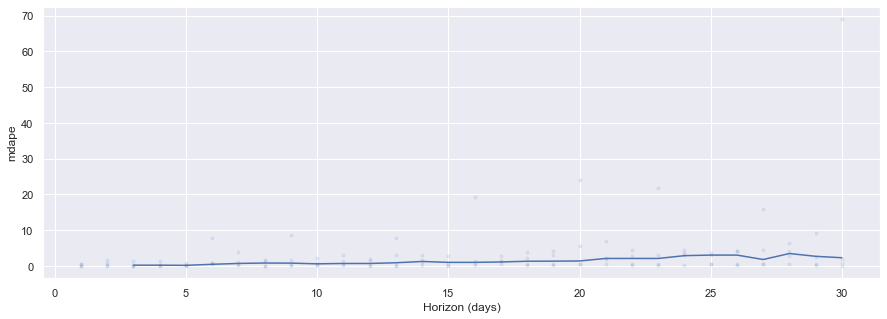

In [93]:
# Plotting Median Absolute Percentage Error: MDAPE
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_crossS, metric='mdape', figsize = (10,30), ax=ax)

plt.show()


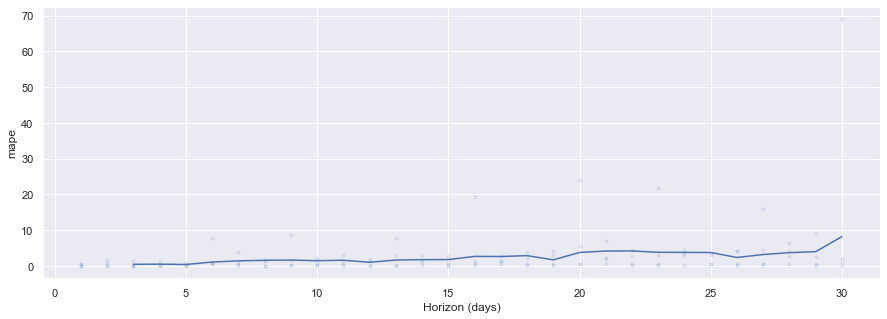

In [97]:
# Plotting resultados da Segunda Dose da Vacina, com MAPE

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='mape', figsize = (10,30), ax=ax)

plt.show()



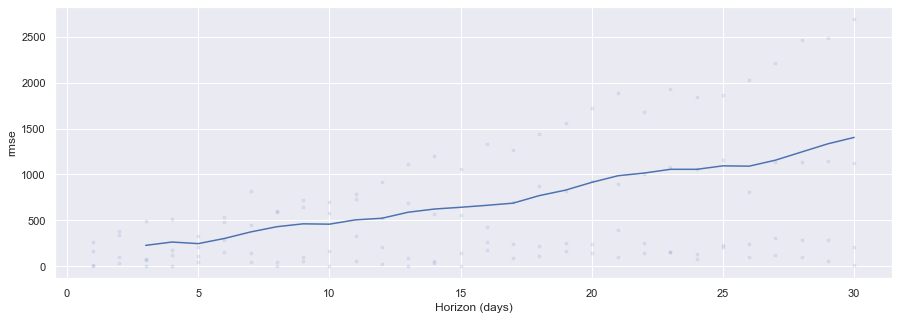

In [98]:
# Plotting Median Absolute Percentage Error: RMSE

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='rmse', figsize = (10,30), ax=ax)

plt.show()
